<a href="https://colab.research.google.com/github/Aderofredo/Aderofredo/blob/main/ML5_ANN_Regression_Inverse_Kinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A regression problem: inverse kinematics with a neural network

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor    # multilayer perceptron for regression (not a classifier)

In [3]:
def direct_kin_(joints, links, origin = [0, 0]):
### implement the forward kinematics for a two joints planar manipulator
    X = np.zeros(3)
    Y = np.zeros(3)
    X[0] = origin[0]
    Y[0] = origin[1]
    X[1] = X[0] + links[0] * np.cos(joints[0])
    Y[1] = Y[0] + links[0] * np.sin(joints[0])
    X[2] = X[1] + links[1] * np.cos(joints[0] + joints[1])
    Y[2] = Y[1] + links[1] * np.sin(joints[0] + joints[1])
    return [X, Y]   # return the coordinates of all link endpoints

In [4]:
class arm():
### the arm class contains all the methods for defining a two joints planar manipulator,
### and implement a neural network inverse kinematics solver for it

    def __init__(self, links = [10, 10], origin = [0, 0], init = [0, 0]):
    # class contructor, defining the basic attributes of the arm and initial configuration
        self.link1 = links[0]
        self.link2 = links[1]
        self.x0 = origin[0]
        self.y0 = origin[1]
        self.joint1 = init[0]
        self.joint2 = init[1]
        self.direct_kin()

    def direct_kin(self):
    # this forward kinematic function calculate the Cartesian coordinates for the current joint configuration
        [self.X, self.Y] = direct_kin_([self.joint1, self.joint2], [self.link1, self.link2], [self.x0, self.y0])

    def plot_arm(self): # Providing a simple visualization of the current configuration of the manipulator.
    # 2D plot of the current arm configuration
        plt.plot([-20,20],[0,0],'k')
        plt.plot(self.X, self.Y, linewidth=2.0)
        plt.plot(self.X, self.Y, 'ro', linewidth=2.0)
        sum_links = (self.link1 + self.link2) * 1.1
        plt.axis([-sum_links, sum_links, -1, sum_links])
        plt.axis('equal')
        plt.show()

    def create_data(self, ann, n_train, n_test):
    # prepare the training and test sets for the neural network solver
        self.inv_solver = ann
        n_data = n_train + n_test
        joint_space = np.hstack((np.random.uniform(low=0, high=np.pi/2, size=(n_data, 1)), np.random.uniform(low=0, high=np.pi, size=(n_data,1))))
        cartesian_space = np.zeros(np.shape(joint_space))
        for i in range(len(joint_space)):
            ax, ay = direct_kin_(joint_space[i], [self.link1, self.link2])
            cartesian_space[i] = [ax[2], ay[2]]
        self.X_train = np.asarray(cartesian_space[:n_train,:])
        self.Y_train = np.asarray(joint_space[:n_train,:])
        self.X_test = np.asarray(cartesian_space[n_train:,:])
        self.Y_test = np.asarray(joint_space[n_train:,:])

    def train_inv_kin(self):
    # train the kinematic solver
        self.inv_solver.fit(self.X_train, self.Y_train)
        score = self.inv_solver.score(self.X_train, self.Y_train)
        print('average training accuracy: ', np.mean(score))

    def test_inv_kin(self):
    # test the kinematic solver
        score = self.inv_solver.score(self.X_test, self.Y_test)
        print('average test accuracy: ', np.mean(score))

    def inv_kin(self, Cartesian):
    # query the trained inverse kinematic solver on a single Cartesian target
        #c_array = np.array(Cartesian).reshape(1,-1)
        joints = self.inv_solver.predict([Cartesian])
        [self.joint1, self.joint2] = joints[0]
        self.direct_kin()
        err = np.sqrt((Cartesian[0]-self.X[2])**2+(Cartesian[1]-self.Y[2])**2)
        return(err, [self.X[2], self.Y[2]])

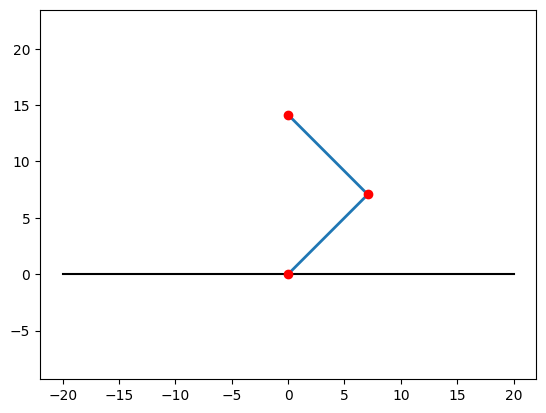

[0.00000000e+00 7.07106781e+00 8.88178420e-16]
[ 0.          7.07106781 14.14213562]


In [5]:
def deg2rad(degrees):
    return degrees*np.pi/180

a = arm(init = [deg2rad(45), deg2rad(90)])
a.plot_arm()
print(a.X)
print(a.Y)

In [6]:
a = arm()

ann = MLPRegressor(max_iter = 1000, hidden_layer_sizes=(20,20))
n_train = 1000
n_test = 100

# How do create pairs of inputs and output to feed to the network for training?
# What value ranges should the inputs and outputs take?

a.create_data(ann, n_train, n_test)
a.train_inv_kin()
a.test_inv_kin()

average training accuracy:  0.9698666480032234
average test accuracy:  0.9689939600416562


In [7]:
ann.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (20, 20),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


target:  [16.56114408 10.32672203]
solution:  [16.18803470779688, 10.887523040546515]
error:  0.6735787817801715


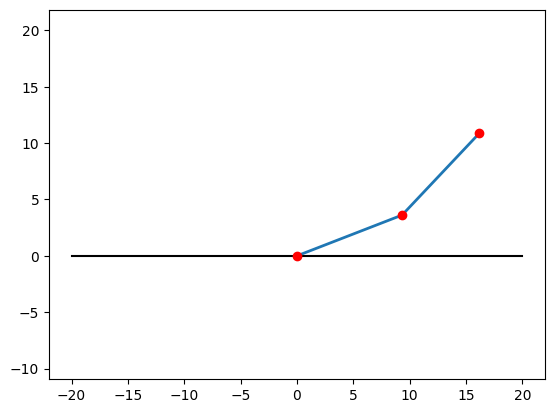


target:  [-2.76716955  2.5286111 ]
solution:  [-2.3287708300614014, 3.144033274768822]
error:  0.755604320062214


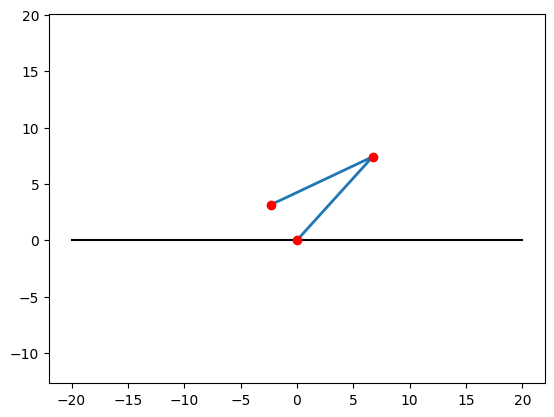


target:  [-0.67369213  0.78689647]
solution:  [-0.2825812131217713, 0.29483614525189417]
error:  0.6285627318802357


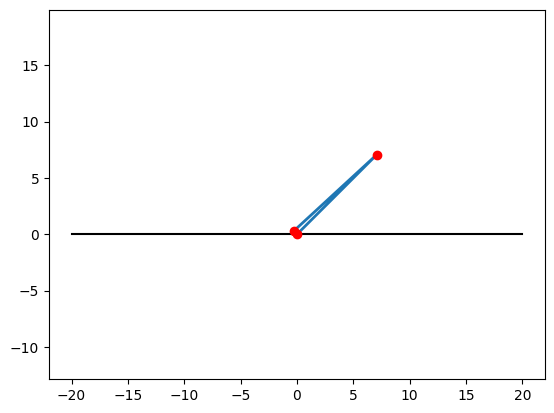


target:  [ 0.1959128  15.03759614]
solution:  [0.8261033285132235, 15.685508551217453]
error:  0.903842128713577


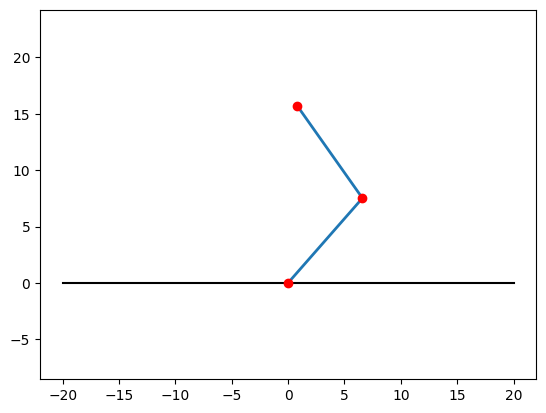


target:  [0.77508338 6.84546603]
solution:  [0.21777969795488872, 6.790753061518583]
error:  0.5599829520189206


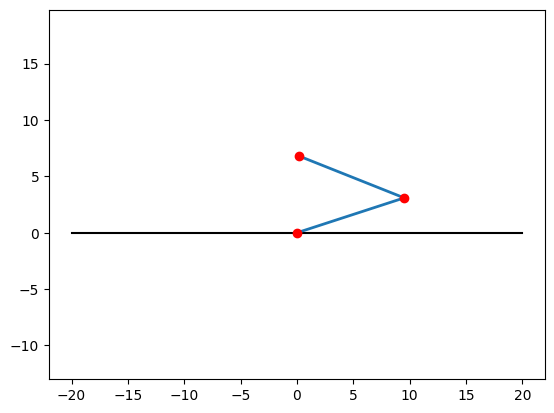


target:  [14.66960126 10.15147513]
solution:  [15.47230455024146, 10.094856739075146]
error:  0.8046975939825841


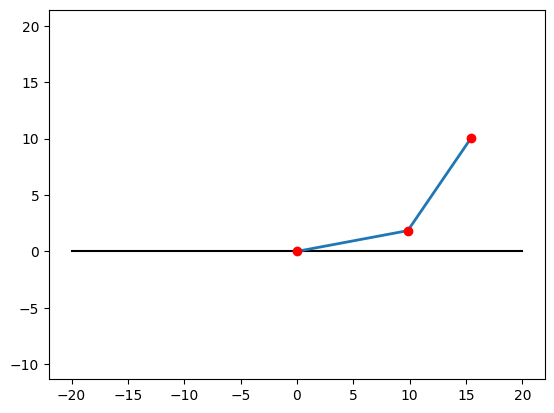


target:  [-1.37958483 13.31079824]
solution:  [0.2727610318295346, 13.890136060313402]
error:  1.7509652045786273


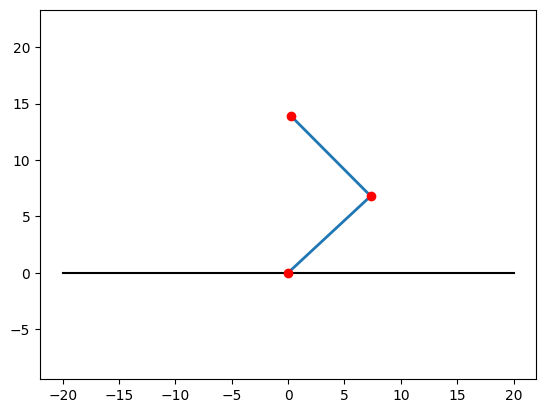


target:  [17.34490562  9.5009707 ]
solution:  [16.022344923594645, 11.427747947792835]
error:  2.337014627350043


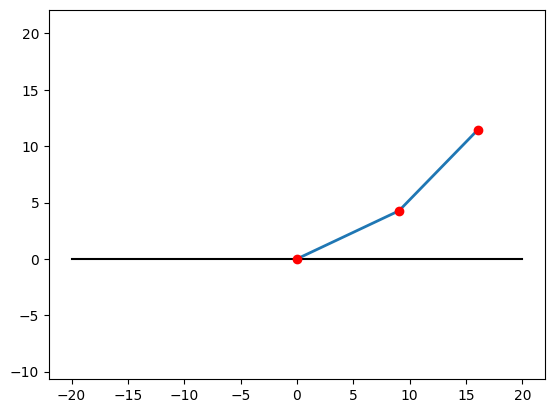


target:  [ 4.37500722 17.56230767]
solution:  [4.1789064337910125, 17.925967663686805]
error:  0.4131635359817239


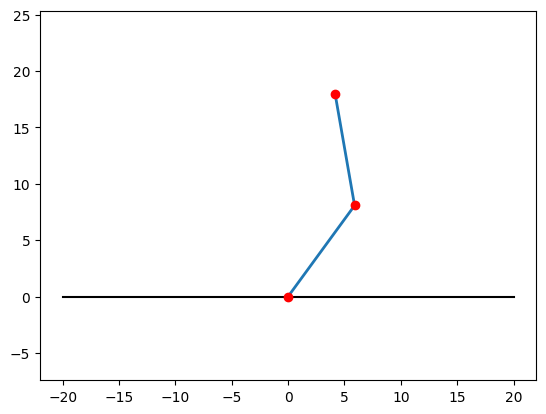


target:  [-0.29415715  1.33799178]
solution:  [-0.026903711643605277, 0.07169834506251815]
error:  1.2941883458028776


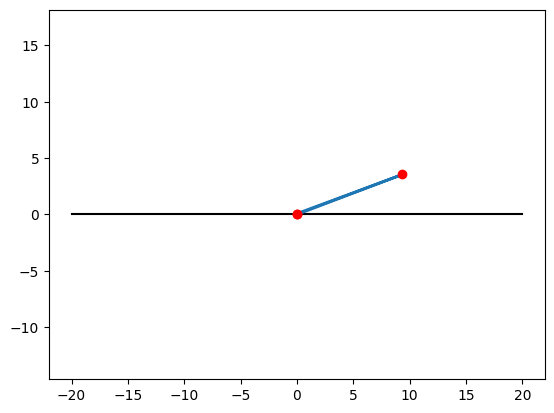


target:  [-7.47250659  5.93400244]
solution:  [-7.722946614774055, 5.847420738221251]
error:  0.2649841428229882


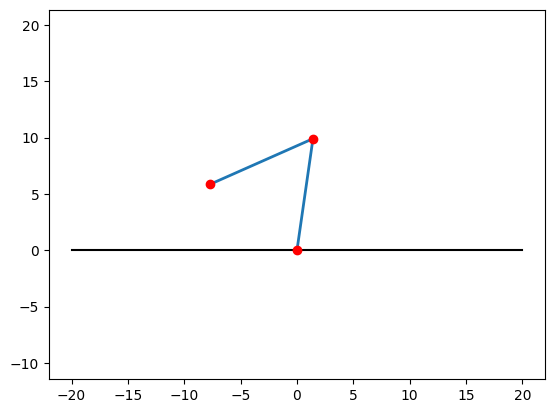


target:  [-3.54181382  4.65989229]
solution:  [-2.918974527557843, 4.109437816718547]
error:  0.8312213398179213


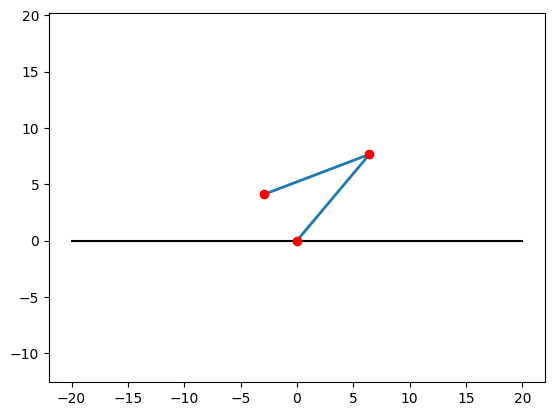


target:  [ 9.62915351 13.24931301]
solution:  [9.979053185139023, 14.011992671432166]
error:  0.8391126547313995


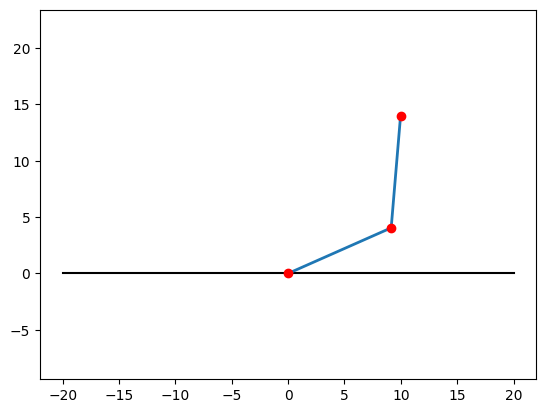


target:  [ 6.13045398 10.14721494]
solution:  [6.690303889235617, 10.030147624892983]
error:  0.5719586296680796


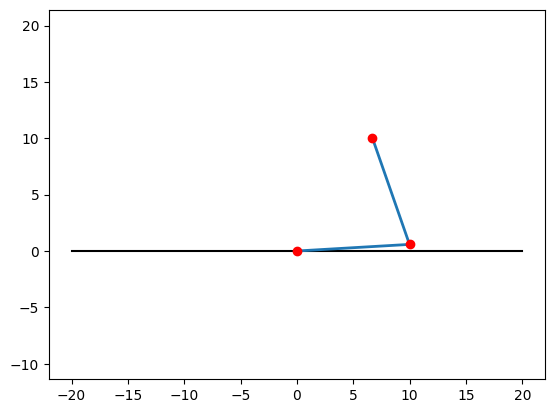


target:  [-0.88245531  2.68102171]
solution:  [-0.5827223867394302, 1.0973804107195857]
error:  1.611756681159306


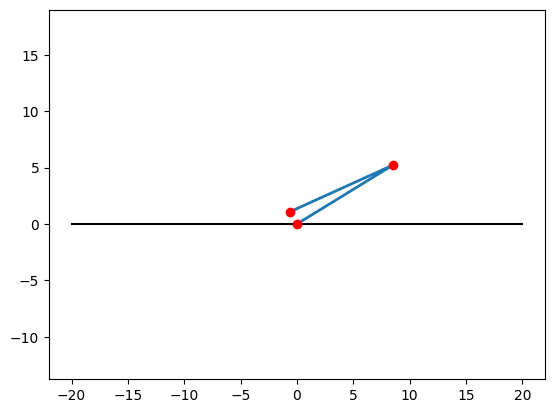


target:  [-0.11105756  1.08104563]
solution:  [0.002274742575339772, -0.006038322188528511]
error:  1.0929756285515362


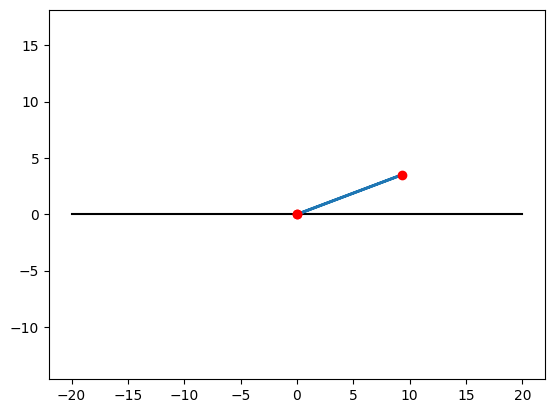


target:  [-0.67500826  1.9017629 ]
solution:  [-0.15306744748600742, 0.27808636173263057]
error:  1.7055051215394943


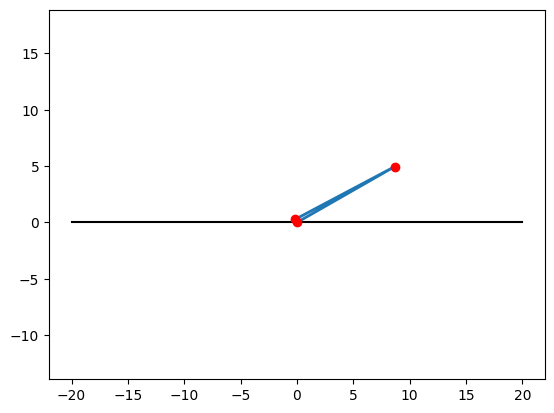


target:  [-5.58818142 16.81273328]
solution:  [-5.422719936921769, 16.800611995737178]
error:  0.16590488081466223


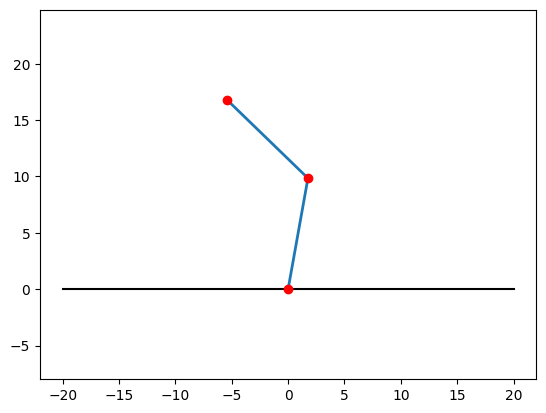


target:  [-1.92188981  5.78881964]
solution:  [-2.219954387580634, 4.917711616682347]
error:  0.9206908678792589


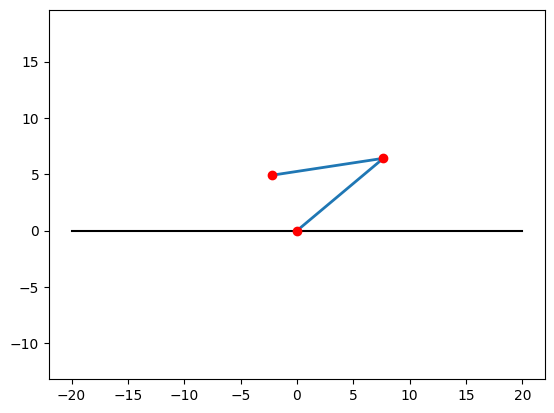


target:  [ 5.85906174 16.13979846]
solution:  [5.542438905349199, 16.997758457302368]
error:  0.9145192052377787


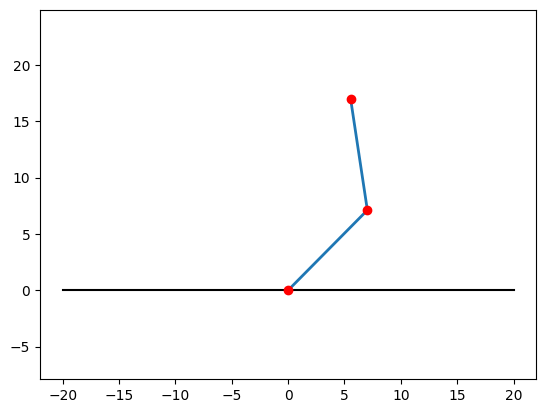


target:  [-3.25822875  0.86458368]
solution:  [-3.0651183399830453, 0.6736427548538604]
error:  0.2715696341349644


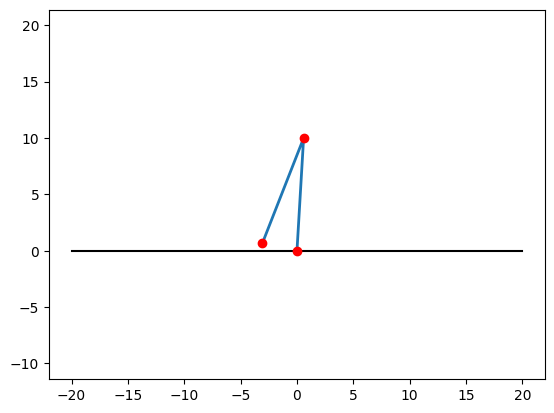


target:  [-0.35720849  0.77394557]
solution:  [0.06805050109361943, -0.09128691417354062]
error:  0.9640915228378436


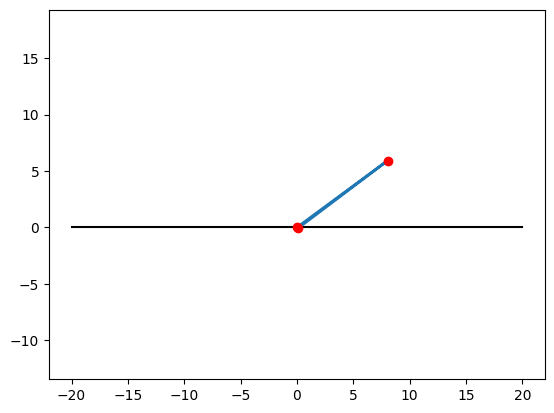


target:  [-1.4333562   0.72540091]
solution:  [-1.4522568305083592, 0.8414954146654559]
error:  0.11762298789298871


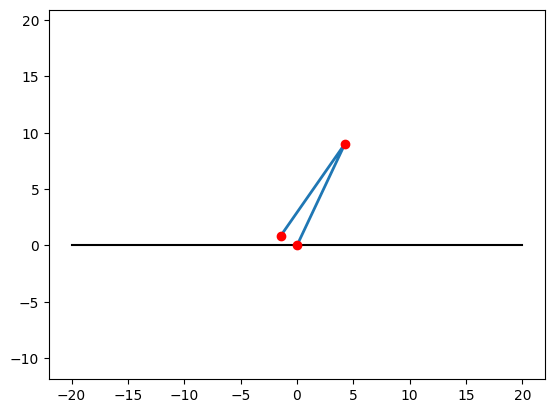


target:  [ 7.3548616  11.61634732]
solution:  [8.015506085417742, 12.11206383874627]
error:  0.8259455246978324


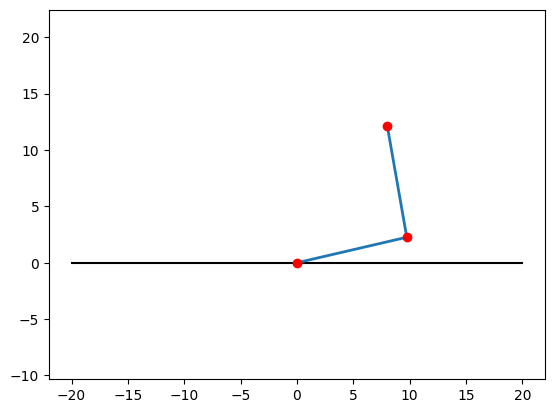


target:  [-7.71769611  7.76591611]
solution:  [-8.086851737005164, 7.280730892195619]
error:  0.6096561059542212


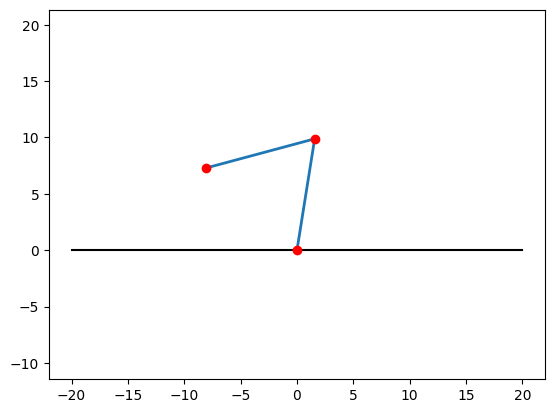


target:  [ 9.71243554 12.89222146]
solution:  [10.063916671545027, 13.638862231509128]
error:  0.825234163436039


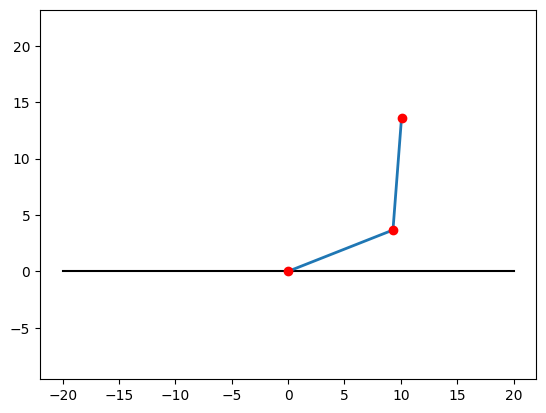


target:  [-0.70713426  0.54456693]
solution:  [-0.6525325476892316, 0.5456630528503688]
error:  0.05461271286528021


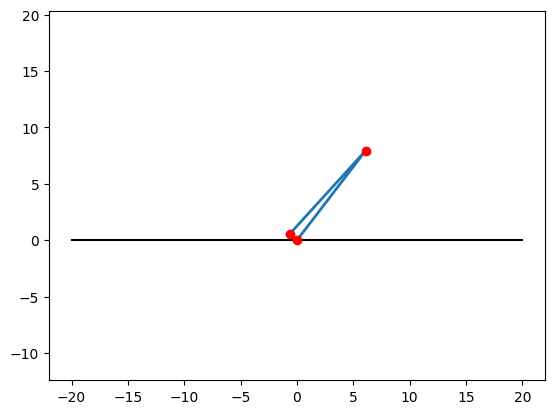


target:  [ 2.46641036 10.64440392]
solution:  [3.4893359979427228, 10.852957974525538]
error:  1.0439691815829668


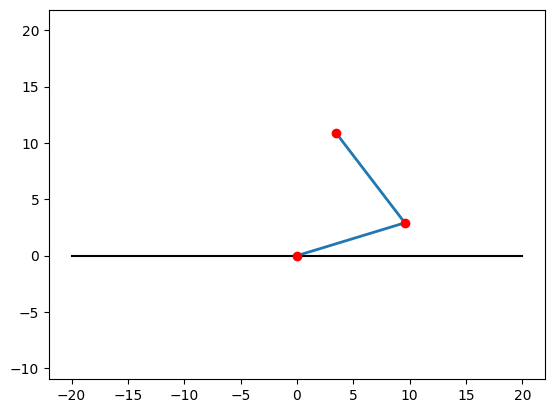


target:  [-1.9383422   1.08493751]
solution:  [-1.7185271829221538, 1.0197699583726756]
error:  0.22927156764533746


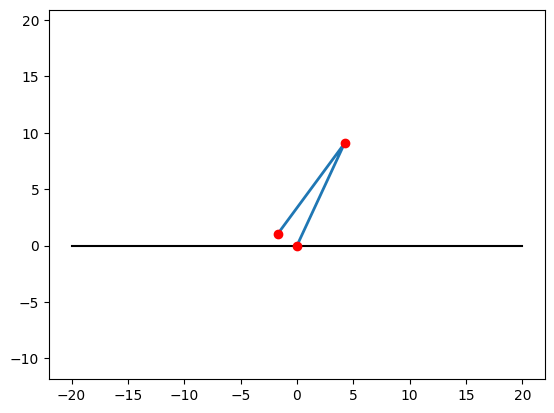


target:  [ 4.12039567 12.03862021]
solution:  [4.984629214802251, 12.727844670232258]
error:  1.105409421583574


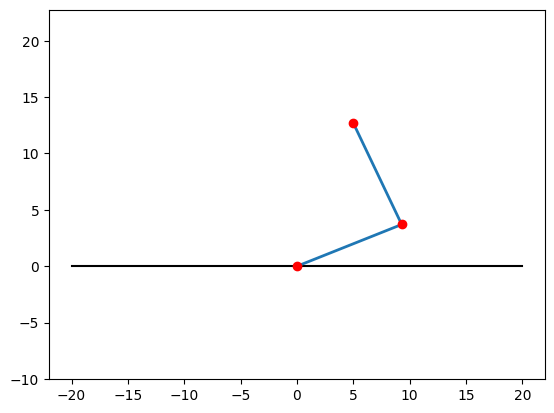


target:  [-0.68550357  0.83335704]
solution:  [-0.2924346831601632, 0.31386967067166793]
error:  0.6514370875464238


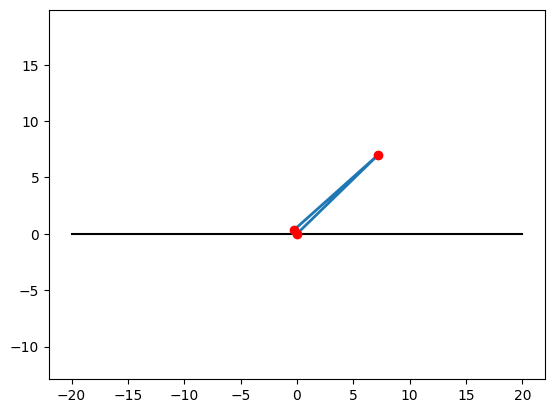


target:  [ 4.19906345 17.81718911]
solution:  [3.8928207560636805, 18.081711445560686]
error:  0.4046685736195322


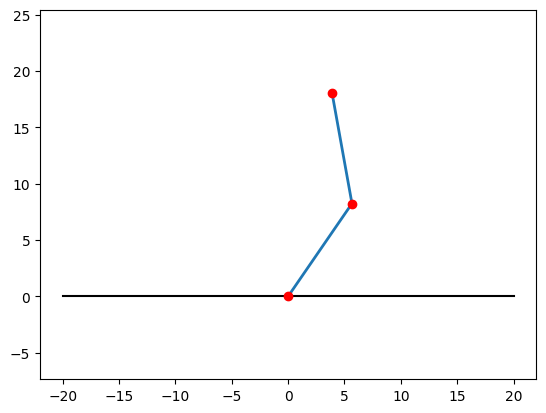


target:  [ 6.16885596 19.02484985]
solution:  [4.868176420257852, 18.815650577235687]
error:  1.3173957674559362


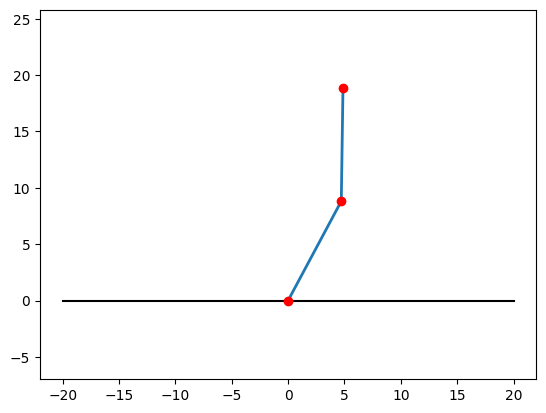


target:  [-2.50489516 16.71369864]
solution:  [-2.307183788790287, 17.25630399093113]
error:  0.5775035513355551


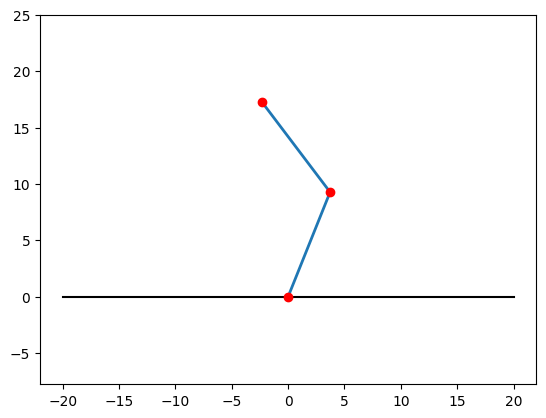


target:  [ 9.46547241 13.56814955]
solution:  [9.815483052815884, 14.3452409349181]
error:  0.8522784036740875


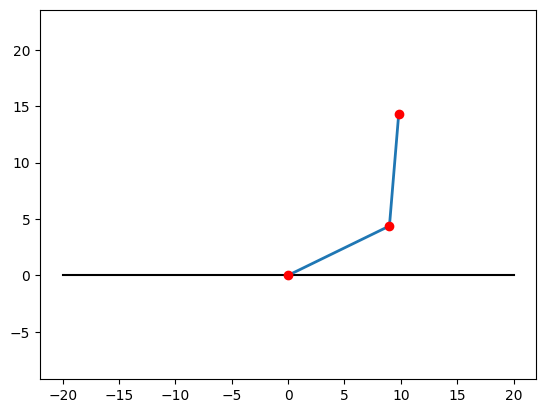


target:  [12.45221919 14.68348699]
solution:  [11.39521134173646, 15.19402092474824]
error:  1.173844322385382


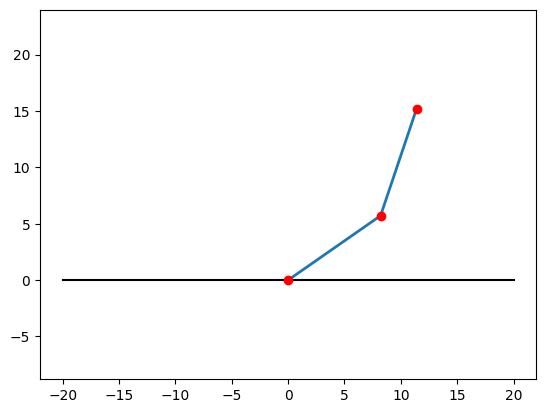


target:  [11.75742947 16.15515916]
solution:  [11.01069174913171, 16.11644992151164]
error:  0.7477403477069015


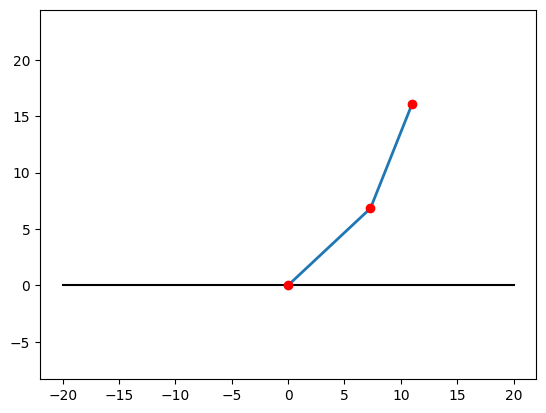


target:  [ 3.96505431 18.53249892]
solution:  [3.3246669322650946, 18.506925162353287]
error:  0.6408978121414786


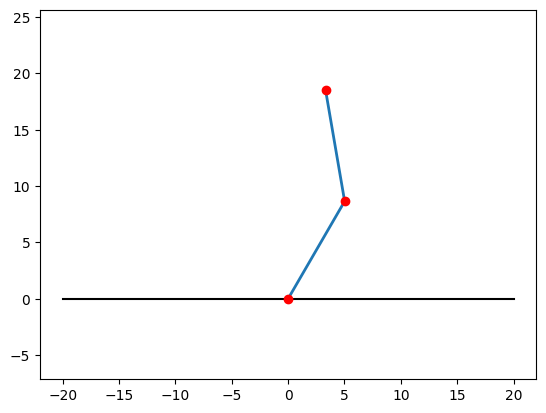


target:  [-2.34084072  7.92310831]
solution:  [-2.784736261416062, 7.46451602985671]
error:  0.6382398629368053


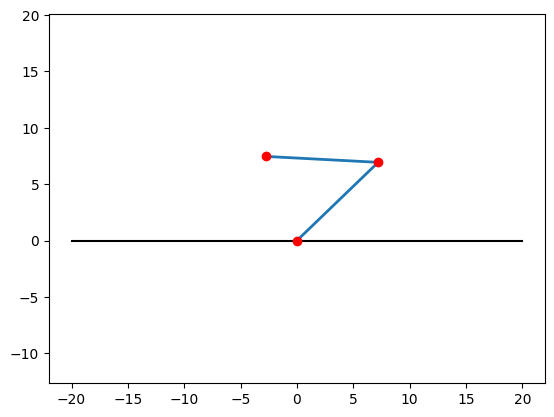


target:  [-2.69858106  1.71658009]
solution:  [-2.743766752113965, 2.00055906960499]
error:  0.2875513965356597


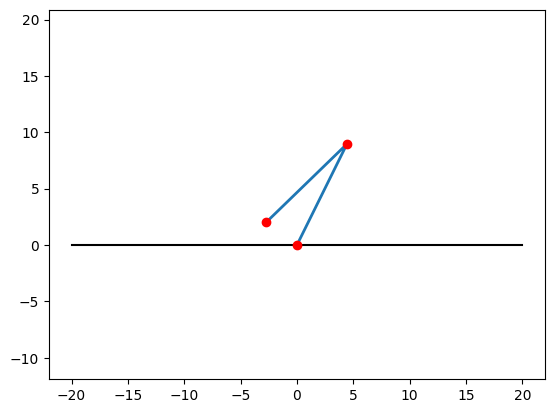


target:  [-3.70067641 14.50400054]
solution:  [-3.1069418316415067, 14.822615931769299]
error:  0.6738223191168161


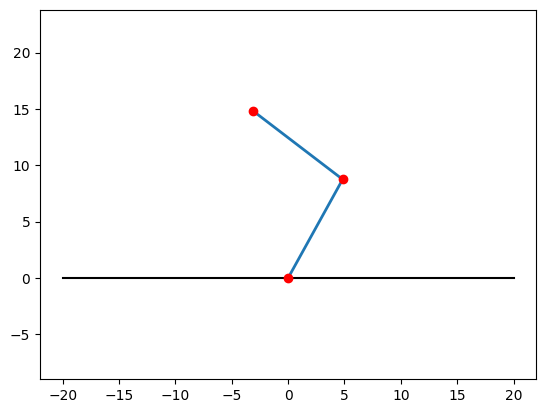


target:  [-2.5427045   3.05110155]
solution:  [-1.913032927293031, 2.7777832438326655]
error:  0.6864322140388797


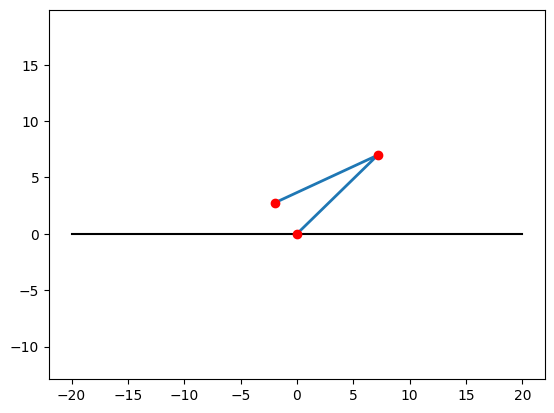


target:  [-8.53509012  8.01788468]
solution:  [-9.169473640570017, 7.197494844036401]
error:  1.0370544561065922


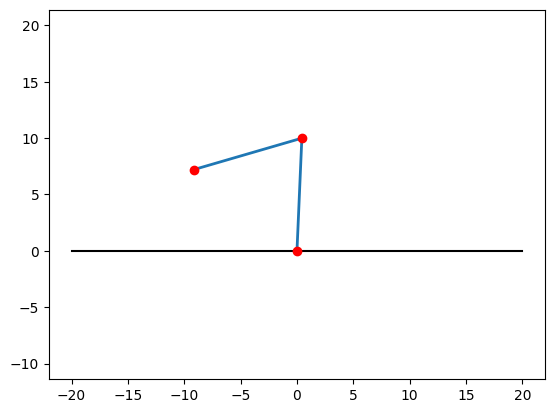


target:  [ 1.20172401 19.47599745]
solution:  [-0.10676310958779212, 19.206376656411223]
error:  1.3359767611889093


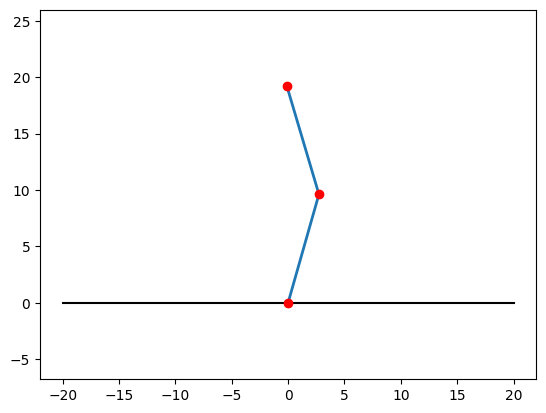


target:  [-5.44408108 14.82641147]
solution:  [-4.651492964603607, 15.164591526346431]
error:  0.8617201848801367


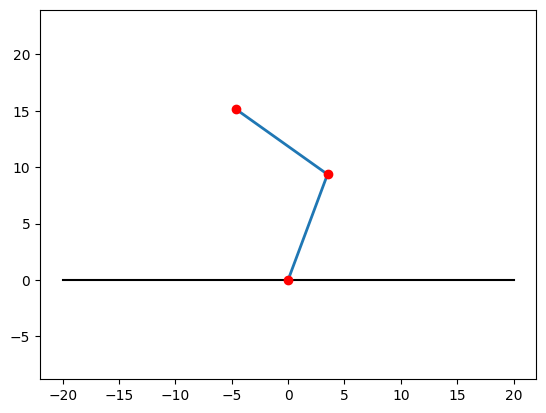


target:  [12.37400073 14.68290126]
solution:  [11.328349086848018, 15.207541222929507]
error:  1.1698865128502287


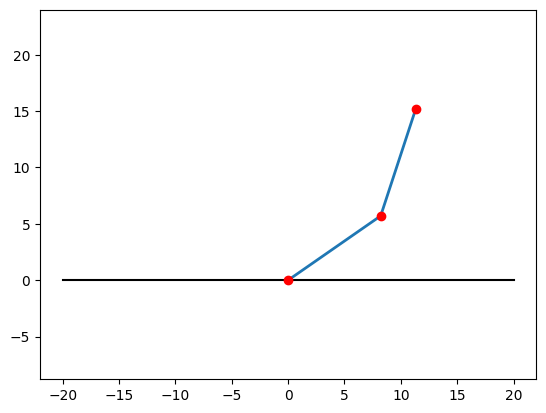


target:  [-3.90851356  2.74396352]
solution:  [-3.841296289423208, 4.153085090239748]
error:  1.4107238452635125


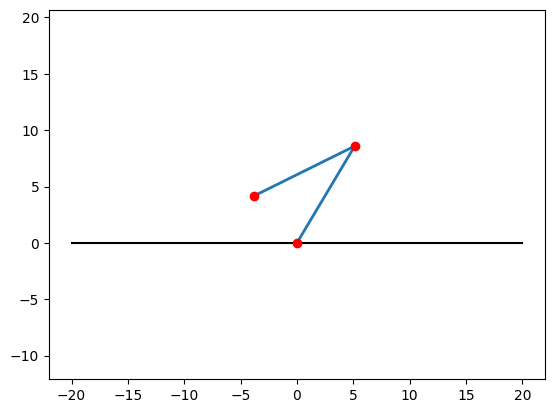


target:  [-3.16374084  6.98084228]
solution:  [-3.3096470319181712, 6.596754402424912]
error:  0.41086751039301966


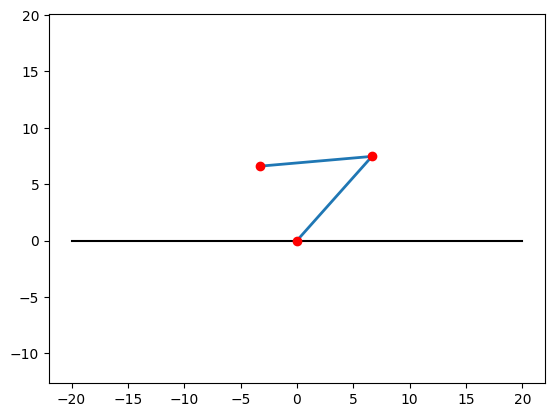


target:  [ 5.25176134 14.81563783]
solution:  [5.466516296583206, 15.810579127480132]
error:  1.0178545418327098


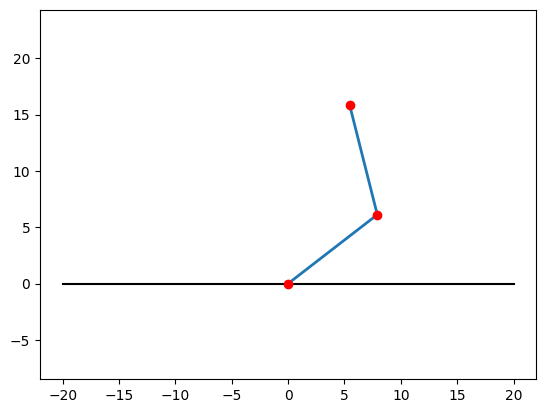


target:  [ 4.05433072 18.3110773 ]
solution:  [3.5206318616435035, 18.382218707154422]
error:  0.5384195125143574


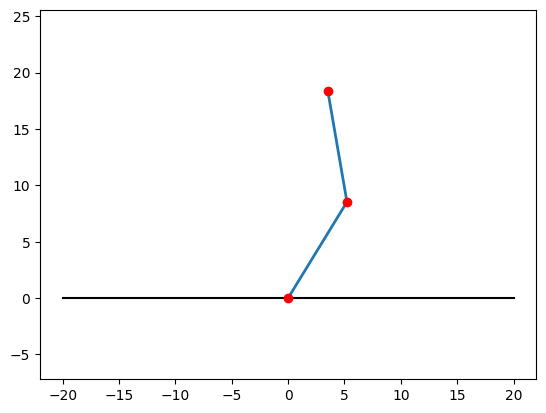


target:  [-5.76392648 14.2621488 ]
solution:  [-5.2308993433634985, 14.613004297172335]
error:  0.6381359627393706


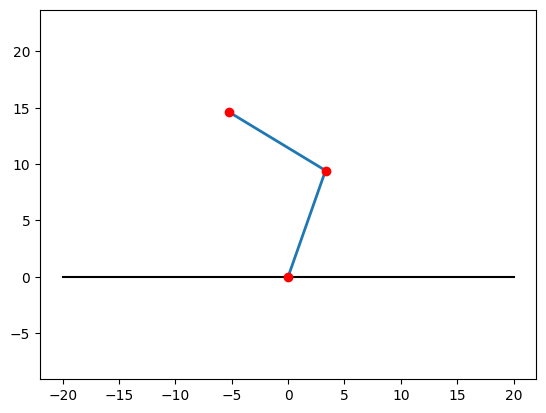


target:  [-4.41688812  1.83388836]
solution:  [-4.51609844510568, 1.671769820803675]
error:  0.19006606452219865


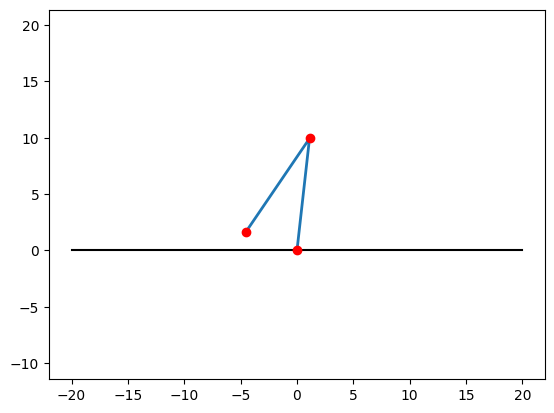


target:  [-0.53793551  1.89176062]
solution:  [-0.06796110229034724, 0.1321269520884032]
error:  1.8213145219522506


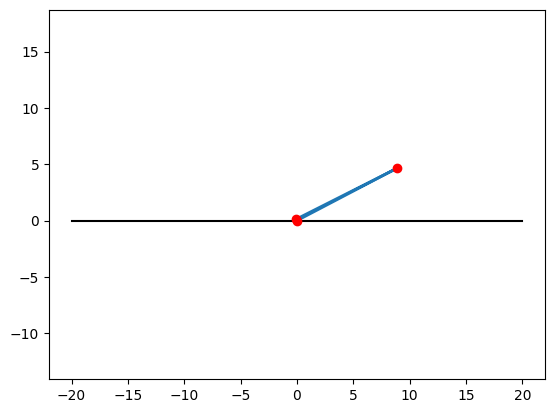


target:  [13.85570399 14.42272734]
solution:  [13.041048547188563, 14.429745723100131]
error:  0.8146856770070484


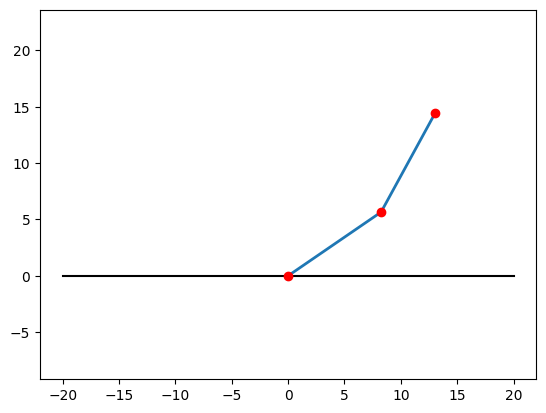


target:  [-1.61301367  1.89129453]
solution:  [-1.1093644584161586, 1.7873651722956554]
error:  0.5142604782415415


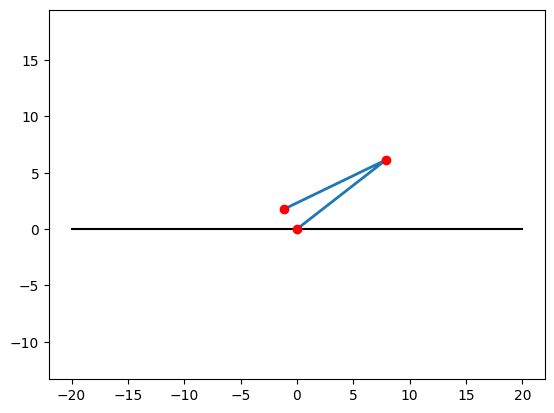


target:  [18.82193077  4.8129443 ]
solution:  [19.260904635201484, 4.750664854832857]
error:  0.44336980957429606


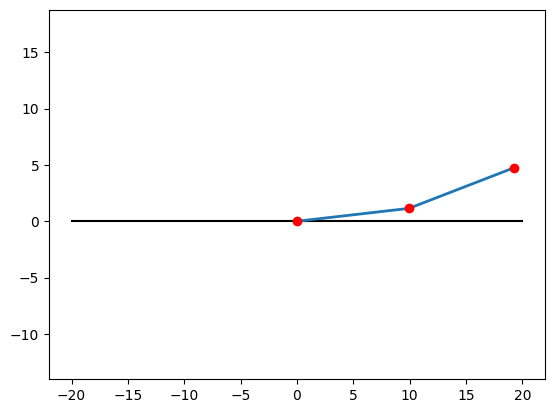


target:  [-3.52744321 16.92479435]
solution:  [-3.353199065306527, 17.307279405860417]
error:  0.42030446500449814


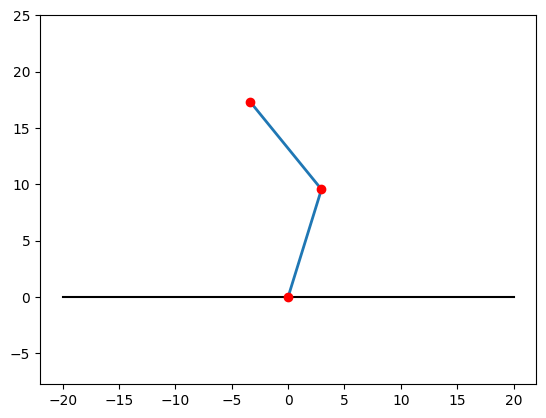


target:  [ 8.97377445 17.51532332]
solution:  [8.147349966303095, 17.67969344895167]
error:  0.8426119902480825


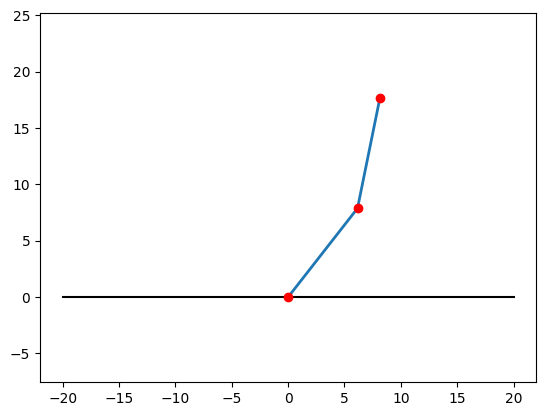


target:  [-8.22384476  8.97454219]
solution:  [-8.760743263220125, 8.205907426236088]
error:  0.937581675576927


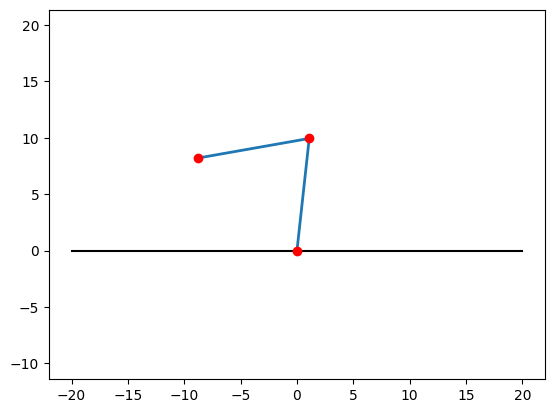


target:  [2.53697861 8.18770796]
solution:  [2.8225198684939627, 8.569530863542946]
error:  0.4767835363501791


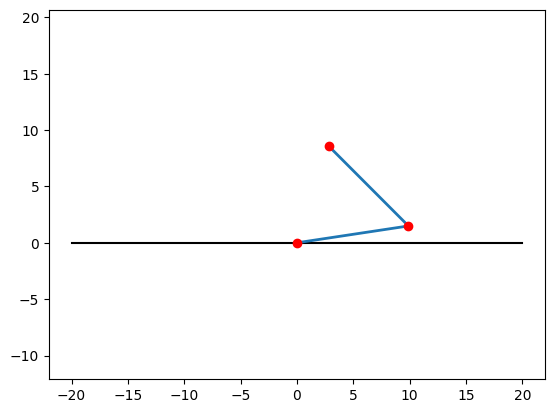


target:  [-0.32449655 13.22623717]
solution:  [1.044623247237845, 13.673612007265001]
error:  1.4403587289931097


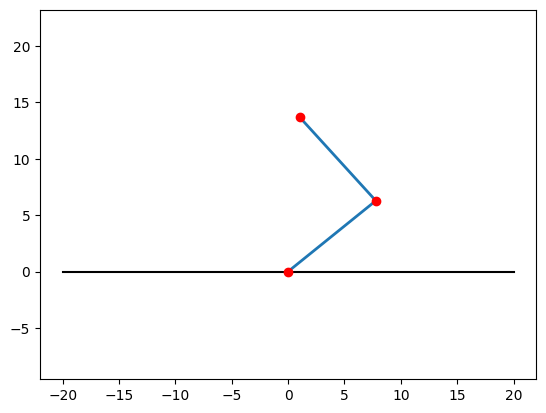


target:  [-0.4397324   0.52724716]
solution:  [-0.22708830776409528, 0.23275148377374055]
error:  0.363242636658941


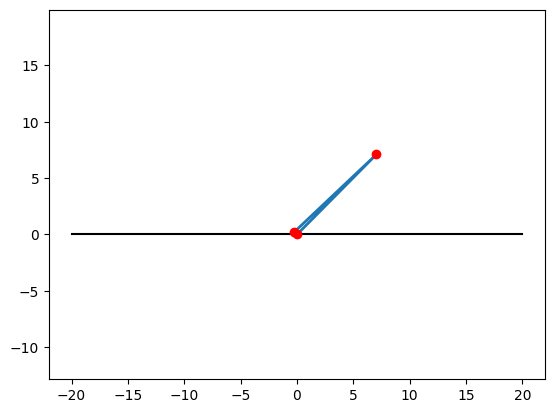


target:  [ 9.73262912 17.46815468]
solution:  [8.790513506013871, 17.505589614362105]
error:  0.9428590625033565


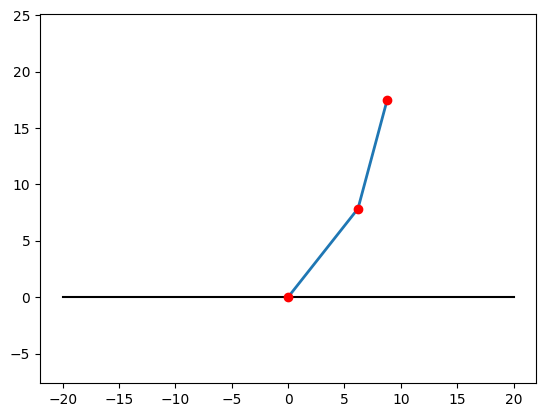


target:  [-0.62721124  1.86438035]
solution:  [-0.11644246096400046, 0.21242555393008367]
error:  1.7291152082363357


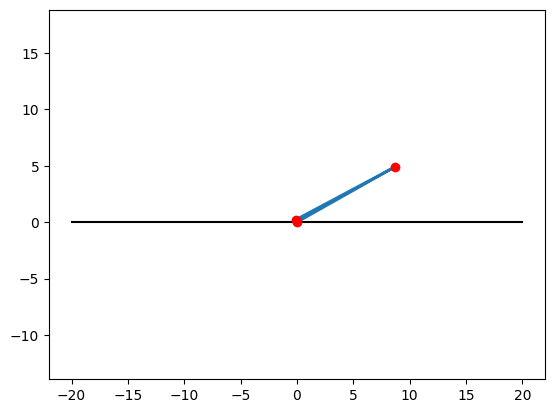


target:  [19.19914669  4.03352766]
solution:  [19.498005991540012, 3.948401288624793]
error:  0.31074649151005457


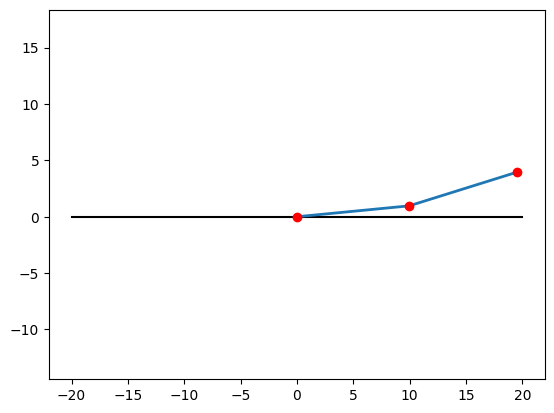


target:  [12.07095571  9.81426042]
solution:  [12.919318752095093, 10.296766216976728]
error:  0.975977302532217


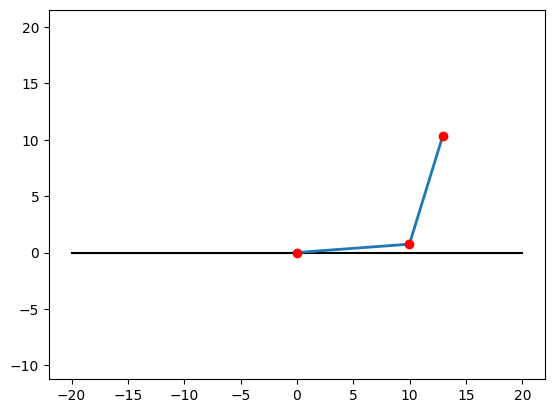


target:  [ 5.76986362 10.47240304]
solution:  [6.499431268548772, 10.344502259002821]
error:  0.7406939723965391


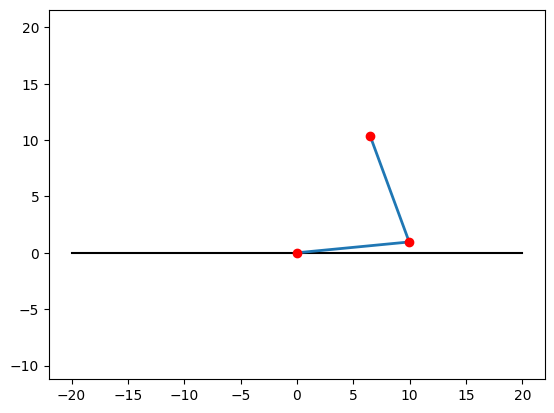


target:  [ 6.55134321 10.08802041]
solution:  [7.0072719672962185, 10.066483912667486]
error:  0.45643712931336416


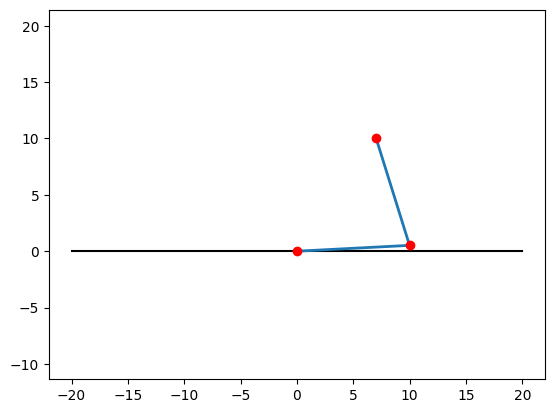


target:  [-5.80225247 11.66690225]
solution:  [-5.797760312470135, 11.952053120797808]
error:  0.2851862495881757


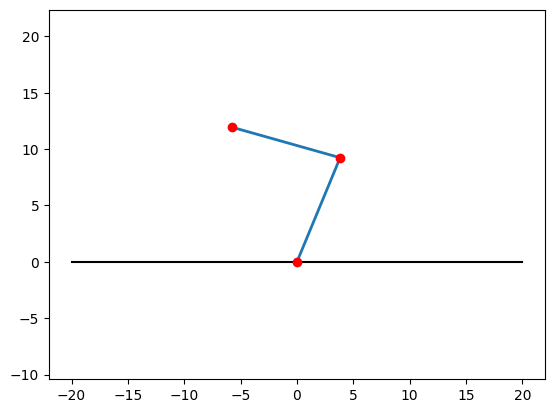


target:  [14.65515812 11.69465194]
solution:  [15.240401741938888, 11.300796916449448]
error:  0.7054302842166053


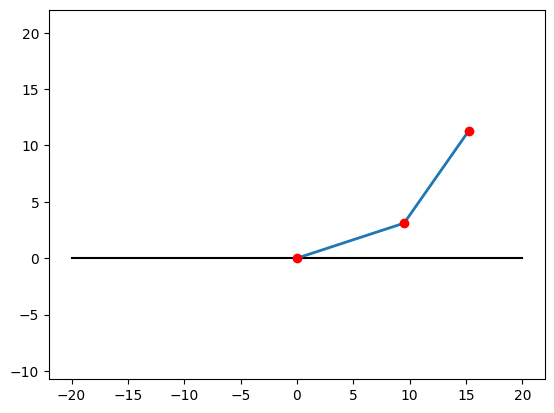


target:  [-2.79938384  1.39113811]
solution:  [-3.0991248788510712, 1.7451053834764263]
error:  0.4638291966392371


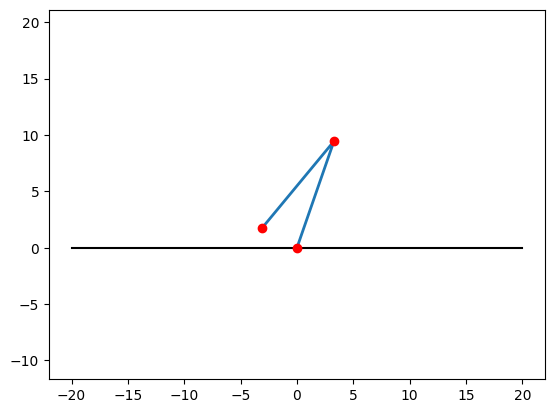


target:  [-0.8480412   5.88103439]
solution:  [-1.1914971240423142, 5.648864104212596]
error:  0.41456605395807294


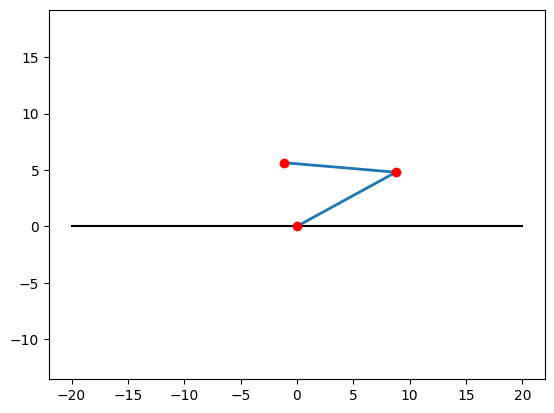


target:  [-2.75141386e-03  1.51509305e+01]
solution:  [0.6213470684755595, 15.823227806726539]
error:  0.9173235792969411


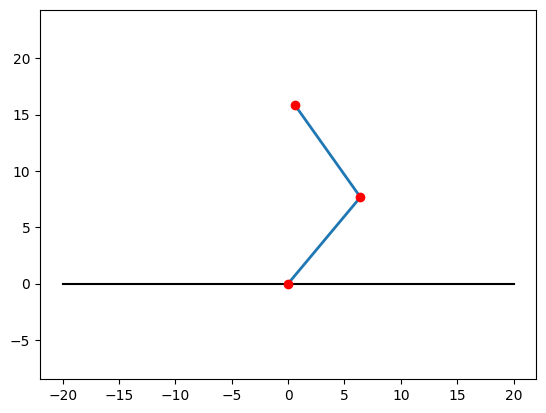


target:  [-5.11393165  5.04127892]
solution:  [-4.903841577230527, 5.463531552739651]
error:  0.4716302873596002


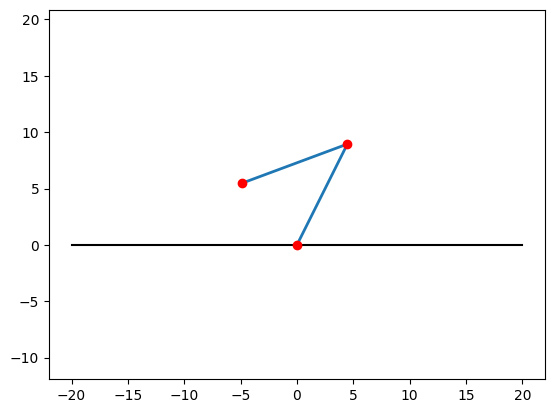


target:  [19.4740114   3.98764598]
solution:  [19.560384101266067, 3.7558970519578265]
error:  0.24732126606202534


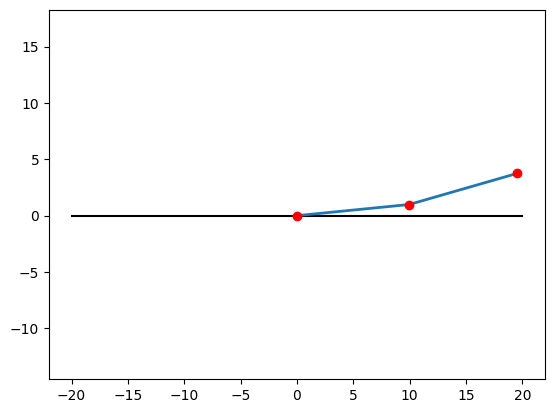


target:  [-4.04828689  5.95458578]
solution:  [-3.720590266338853, 5.6137528287552305]
error:  0.472813045333217


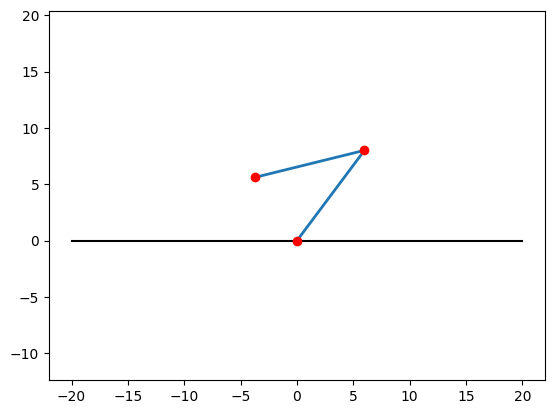


target:  [-2.98957619 14.2866324 ]
solution:  [-1.883774297139321, 14.863996155502704]
error:  1.2474561057477929


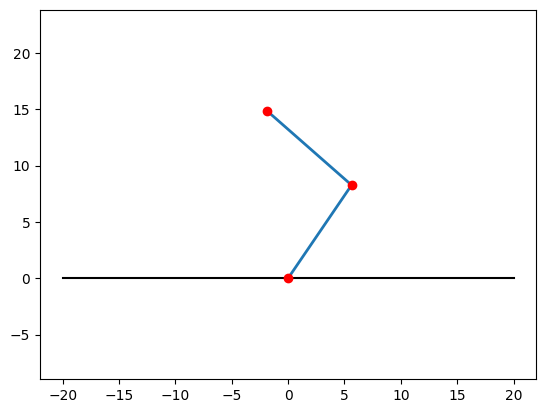


target:  [-1.81135845 12.62984152]
solution:  [0.01475063510289143, 13.187425162607722]
error:  1.909338601679362


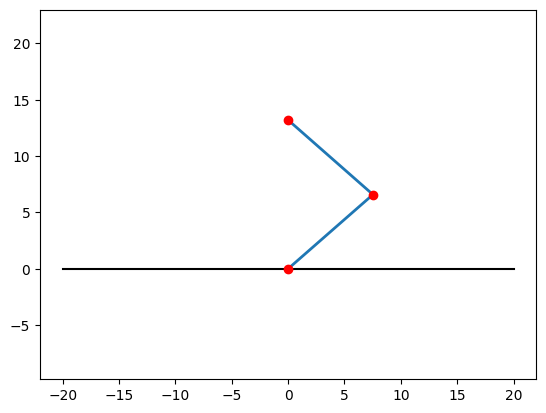


target:  [ 0.01450656 10.58762871]
solution:  [0.899271496895949, 10.752378095555343]
error:  0.8999729715715518


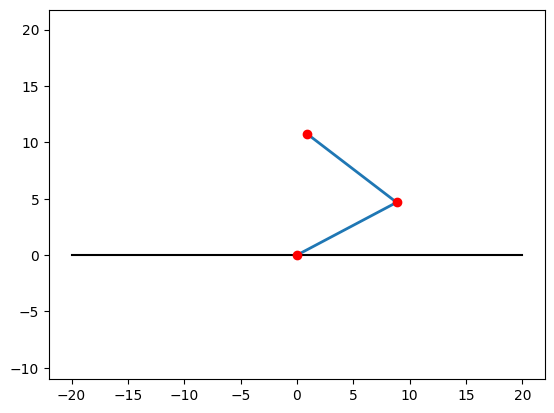


target:  [-0.16549626  2.06472499]
solution:  [-0.17758760067017754, 0.5612991845815092]
error:  1.503474423180736


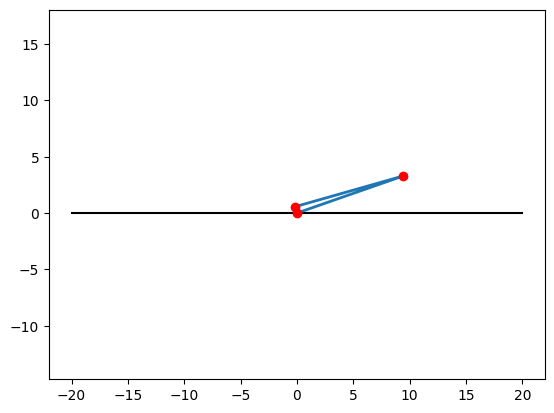


target:  [-7.49812323  8.30669704]
solution:  [-7.803615537136393, 7.779383350750205]
error:  0.609413878098817


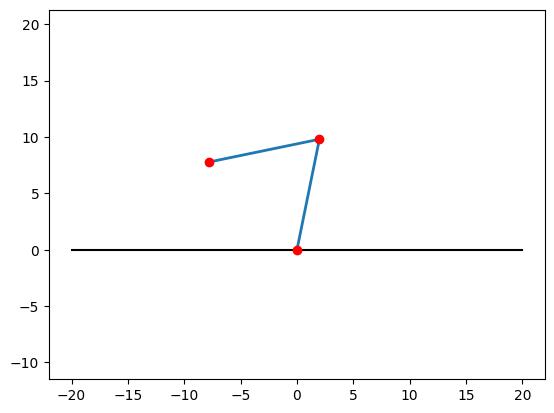


target:  [-0.45517018  6.83671774]
solution:  [-0.4199016356670242, 7.158199945461358]
error:  0.3234110050298401


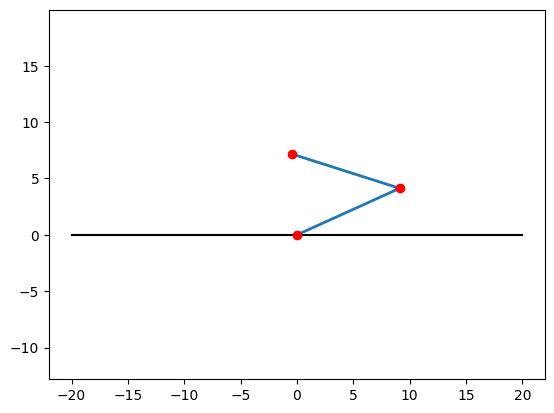


target:  [-0.85474514  0.10854966]
solution:  [-2.087566493618896, 1.2324250424335812]
error:  1.6682159191230723


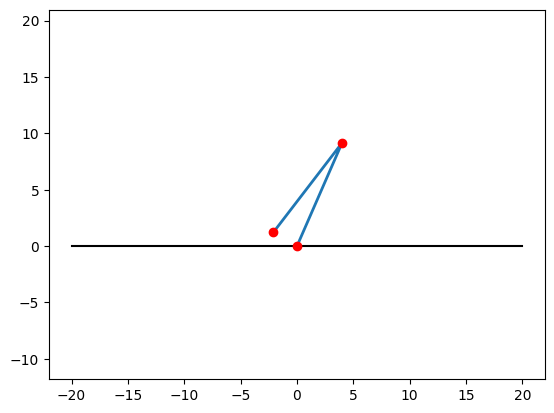


target:  [-5.64845072  8.96042366]
solution:  [-5.73208017489904, 9.023786109342803]
error:  0.10492228061705035


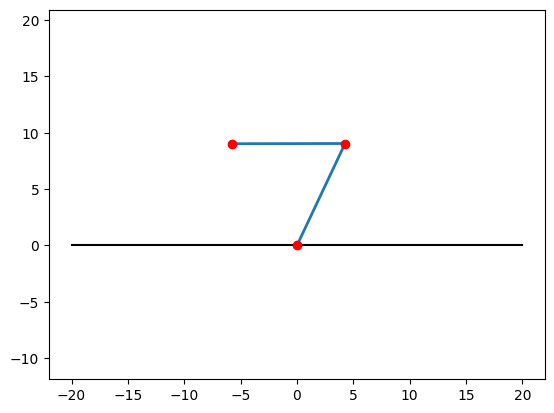


target:  [-1.48588538 12.80905892]
solution:  [0.340362727515898, 13.30124244150495]
error:  1.891408675081339


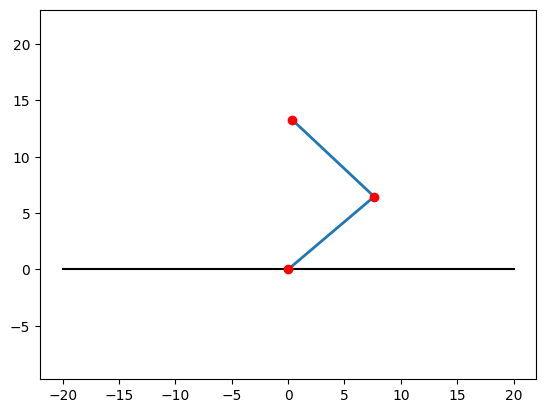


target:  [-2.14342366 19.20861499]
solution:  [-3.4806958314316674, 18.73043751123786]
error:  1.4201938479381921


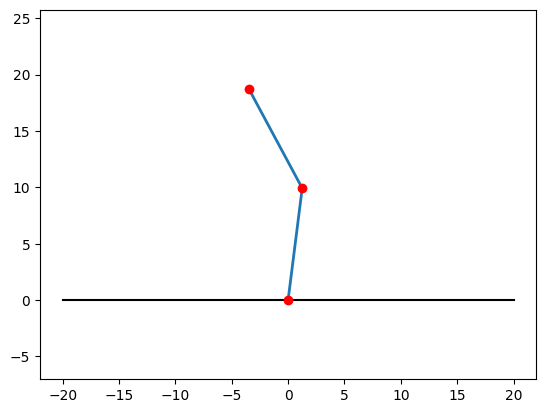


target:  [-4.17300543 12.24733681]
solution:  [-3.8448567365147683, 12.523742653687915]
error:  0.4290475000414873


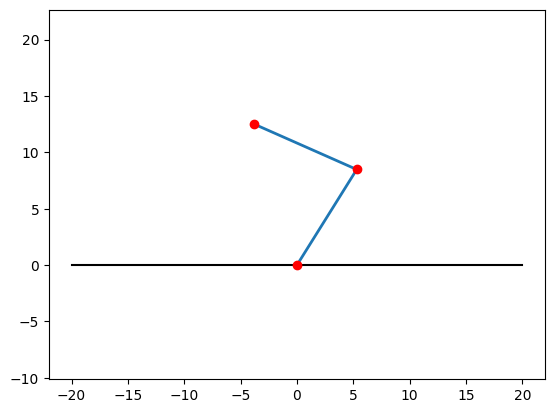


target:  [-1.30983754 14.49762589]
solution:  [-0.1492810872470658, 15.235581750527466]
error:  1.3753072859671307


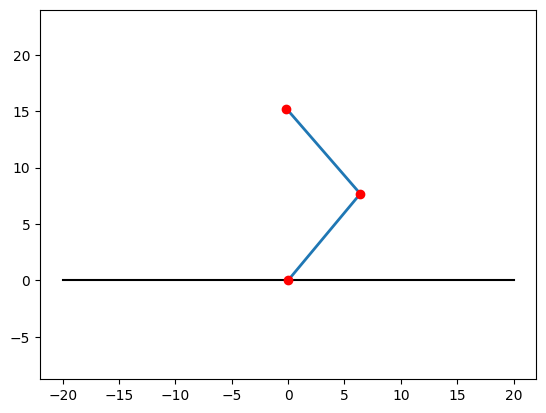


target:  [-7.86497115 15.4882452 ]
solution:  [-7.632473481462863, 15.330046154463151]
error:  0.28121540703272857


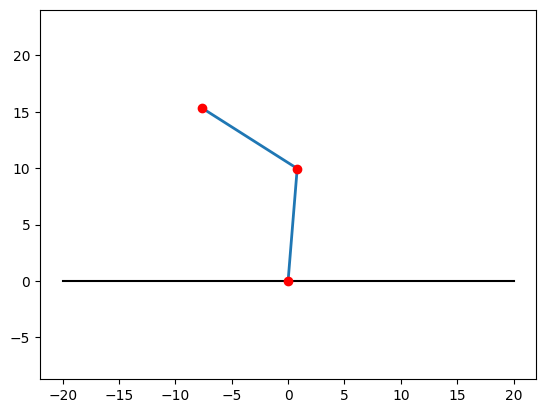


target:  [-0.40561563  0.37181399]
solution:  [-0.39666451962322924, 0.3696779422815686]
error:  0.009202444326160788


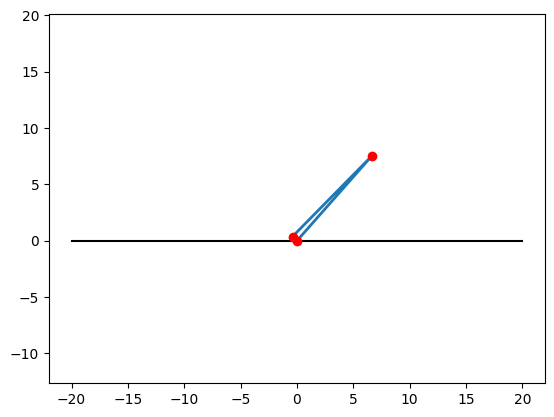


target:  [17.80552428  8.8182597 ]
solution:  [17.33128034603982, 9.244919726951538]
error:  0.6379232642681779


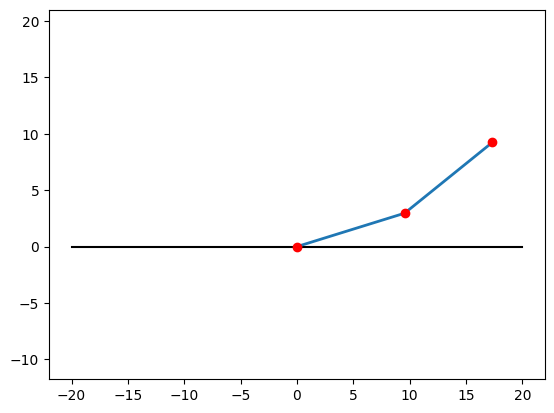


target:  [ 1.2640875  11.13278484]
solution:  [2.082799540009338, 11.192301185670413]
error:  0.8208724637989977


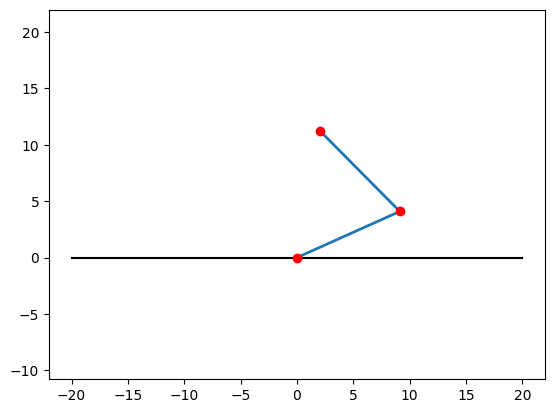


target:  [-3.60517683  8.14355356]
solution:  [-3.810455765920125, 7.987662722390396]
error:  0.25776228686565356


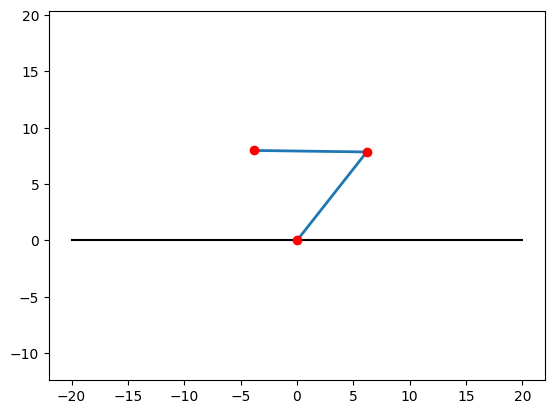


target:  [-2.5388903   1.39513996]
solution:  [-2.695395481279465, 1.6588821700368994]
error:  0.30668195509304824


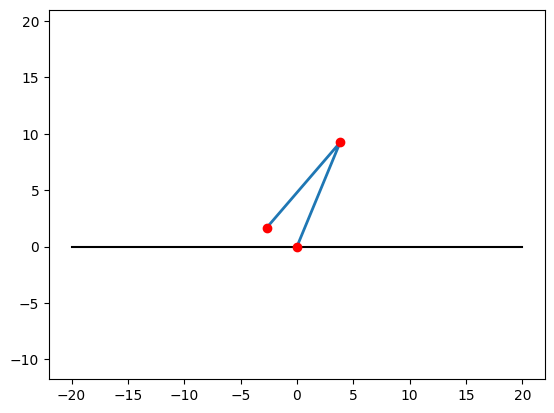


target:  [-3.80005096 11.03677566]
solution:  [-3.781222646489571, 11.209817906892479]
error:  0.1740635659219936


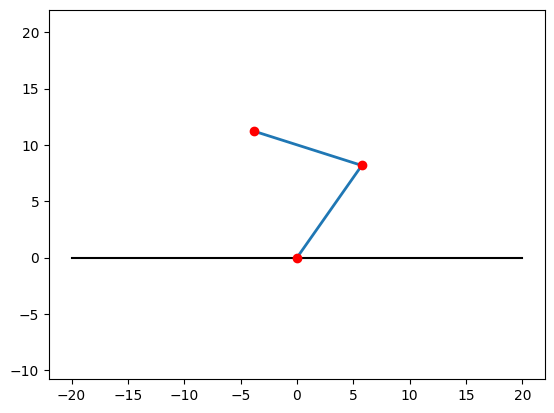


target:  [-4.61019195  6.76120939]
solution:  [-4.401884529613502, 6.5669750900703]
error:  0.28481387751362636


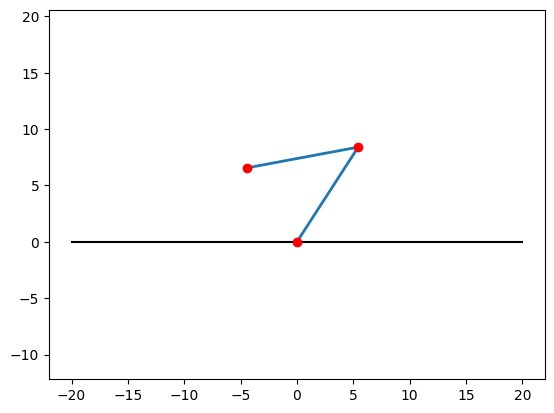


target:  [ 4.49590945 16.97154019]
solution:  [4.541016383999231, 17.51730826027364]
error:  0.5476289050567101


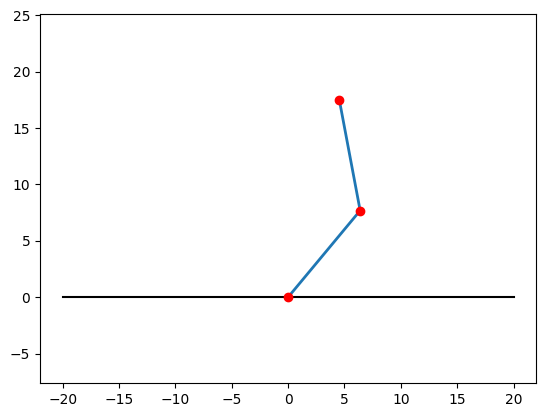


target:  [-1.55960166  4.29408123]
solution:  [-1.5683638387318677, 3.121671858556476]
error:  1.1724421186446707


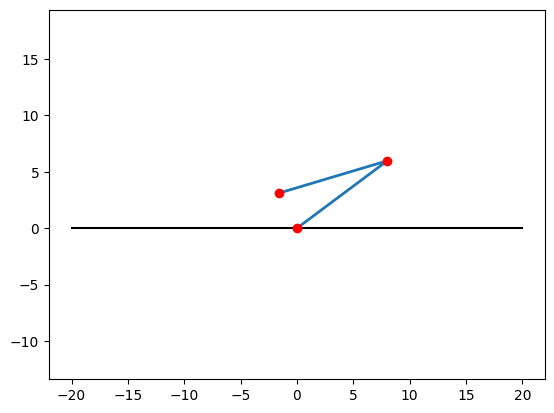


target:  [ 6.19799241 13.47869474]
solution:  [7.4249015617937095, 13.836557902185247]
error:  1.2780344741157557


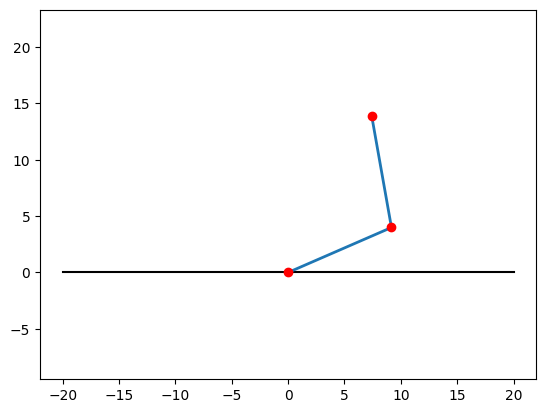


target:  [-0.12341733  0.32573556]
solution:  [-0.07740451843413165, 0.09188888359196756]
error:  0.23833054007334473


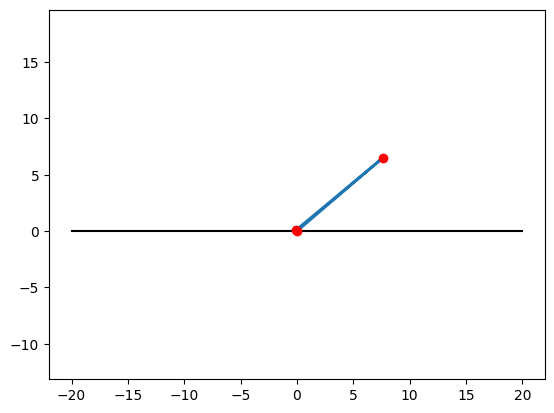

Average error:  0.7894970565312882


In [8]:
tot_err = 0
for t in a.X_test:
    print('\ntarget: ',t)
    [inv_error, config] = a.inv_kin(t)
    print('solution: ', config)
    tot_err += inv_error
    print('error: ', inv_error)
    a.plot_arm()
    plt.pause(2)
tot_err = tot_err/n_test
print('Average error: ',tot_err)